In [76]:
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import statistics
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats


## Doctor and Patient classes

In [77]:
class Patient:
    def __init__(self, NO):
        self.priority = 0
        self.NO = NO 
        self.arrival : float
        self.service_time1 = 0.0
        self.service_time2 = 0.0
        self.doctor1 = Doctor('None', 5)
        self.doctor2 = Doctor('None', 5)
        self.end1 = T + 1
        self.end2 = T + 1
        self.wt1 = 0.0
        self.wt2 = 0.0
        self.twt = 0.0

        
    def __eq__(self, other):
        return self.NO == other.NO
    
    def priorityy(self):
        global gen_i
        if lst[gen_i] > 0.85:
            self.priority = 3
        else:
            self.priority = 1
        gen_i += 1
    
class Doctor:
    def __init__(self, number, status = 0):
        self.number = number
        self.status = status #0 means idle and 1 means busy
        self.svr = 0.0
        self.num_visited = 0
    def __eq__(self, other):
        return self.number == other.number



## Random number generator

In [78]:
class CLCG:
    def __init__(self, K):
        self.K = K
        self.A = [0.0 for i in range(K)]
        self.m  = [0.0 for i in range(K)]
        self.length = 0
        self.seed = [1 for i in range(K)]
        self.c = [0.0 for i in range(K)]

    def element_wise_multiply(self, vector1, vector2):
        result = [vector1[i] * vector2[i] for i in range(len(vector1))]
        return result
    
    def element_wise_remainder(self, vector1, vector2):
        result = [vector1[i] % vector2[i] for i in range(len(vector1))]
        return result
    
    def next(self,x = []):
        result = 0
        for i in range(len(x)):
            result += (((-1)**i) * x[i])
        result = result % (self.m[0] - 1)
        if result ==0:
            result = (self.m[0] - 1) / self.m[0]
        else:
            result = result / self.m[0]
        return result

    def maxlength(self):
        P = 1
        for i in range(self.K):
            P = P * (self.m[i] - 1)
        P = P / pow(2, self.K - 1)
        return P
    def generate(self, length):
        X = np.empty([length, self.K])
        X[0] = self.seed
        result = np.empty(length)
        for i in range(1, length):
            
            X[i] = self.element_wise_remainder([x + y for x, y in zip(self.element_wise_multiply(X[i-1], self.A), self.c)], self.m) 

        for i in range(length):
            result[i] = self.next(X[i])
            
        return result
    def d_alpha(self, a, n):
        result = math.sqrt(((-1) / (2 * n)) * math.log(2 * a))
        return result
    
    def KS_test(self, data : np.array, a = 0.05):
        n = len(data)
        sorted_data = np.sort(data)
        ecdf = np.arange(1, n + 1) / n  # Empirical CDF
        cdf = sorted_data  # CDF of the uniform distribution in the interval [0, 1]
        d_stat = np.max(np.abs(ecdf - cdf))
        
        # Calculate critical value
        d_alpha = self.d_alpha(a , n)
        if d_alpha >= d_stat :
            print("KS Test: Fail to reject null hypothesis (data follows uniform distribution)")
            return True
        else:
            print("KS Test: Reject null hypothesis (data does not follow uniform distribution)")
            return False
    

In [79]:
def st(lst, mu, var): # calculates the service time of a customer
    global gen_i
    R = lst[gen_i]
    R2 = lst[gen_i + 1]
    R3 = lst[gen_i + 2]
    Z1 = math.sqrt((-2) * math.log(R)) * math.cos(2 * math.pi * R2)
    X1 = mu + Z1 * (var)
    Z2 = math.sqrt((-2) * math.log(R)) * math.sin(2 * math.pi * R2)
    X2 = mu + Z2 * (var)
    if R3 > 0.5:
        result = X1
    else:
        result = X2
    gen_i += 3
    return abs(result)

def at(Tnow, lst, mu, var): # calculates the arrival time of a customer
    global gen_i
    R = lst[gen_i]
    R2 = lst[gen_i + 1]
    R3 = lst[gen_i + 2]
    Z1 = math.sqrt((-2) * math.log(R)) * math.cos(2 * math.pi * R2)
    X1 = mu + Z1 * (var)
    Z2 = math.sqrt((-2) * math.log(R)) * math.sin(2 * math.pi * R2)
    X2 = mu + Z2 * (var)
    if R3 > 0.5:
        result = X1
    else:
        result = X2
    
    gen_i += 3
    
    return abs(result) + Tnow


In [80]:
ty = CLCG(2)
ty.A = [48271, 40692]
ty.m = [60013, 60017]
ty.seed = [1235, 5879]
maximum_length = ty.maxlength()
lst = ty.generate(100000)

In [81]:
#calculates the minimum value of ith column of my_list list
def min_lst(my_list, i):
    #starting from infinity and iterating over list to find global min
    min_value = float('inf')
    for sublist in my_list:
        
        # Compare the first element of each sublist to find the minimum
        if sublist[i] < min_value:
            min_value = sublist[i]
    return min_value
#calculates the minimum value of ith column of my_list list
def max_lst(my_list, i):
    max_value = float('-inf')
    #starting from -infinity and iterating over list to find global max
    # Iterate over each sublist in my_list
    for sublist in my_list:
        # Compare the first element of each sublist to find the maximum
        if sublist[i] > max_value:
            max_value = sublist[i]
        return max_value

In [82]:
#normalizing profit variable using linear method
def normalize_profit(x_ij, min, max):
    result = (x_ij - min) / (max - min)
    return result

#normalizing cost variable using linear method
def normalize_cost(x_ij, min, max):
    result = (max - x_ij) / (max - min)
    return result

## checking for free doctors

In [83]:
def free_doctor(doctors):
    free_doctors = []
    #finding free servers
    for doctor in doctors:
        if doctor.status == 0:
            free_doctors.append(doctor)
            
    #handling no free server
    if not free_doctors:
        result = False
    #randomly choosing a free server
    else:   

        result = random.choice(free_doctors)
    return result

## arrival

In [84]:
#arrival
def arrival(i,Patients):
    global FEL, Tnow, Doctors, gen_i, twt1, twt2, twt3, Q1,Q2,Q3
    c = Patient(i + 1)
    c.arrival = at(Tnow, lst,20,4)
    if c.arrival < T:
        FEL.append([0, c.arrival, c])
        c.priorityy()
        Patients.append(c)
    
    chosen_doctor = free_doctor(Doctors1)
    if Patients[i].priority ==1:
        
        if not chosen_doctor:
            Q1.append(Patients[i])
            
        else:
            chosen_doctor.status = 1
            Patients[i].service_time1 = st(lst, 15, 10)
            Patients[i].doctor1 = chosen_doctor
            if Tnow > Ti:
                chosen_doctor.num_visited += 1
                chosen_doctor.svr += Patients[i].service_time1
            Patients[i].end1 = Patients[i].service_time1 + Tnow
            
            FEL.append([1, Patients[i].end1, Patients[i]])

            

    elif Patients[i].priority ==3:
        if not chosen_doctor:
            Q3.append(Patients[i])
        else:
            
            chosen_doctor.status = 1
            Patients[i].service_time1 = st(lst, 30, 5)
            Patients[i].doctor1 = chosen_doctor
            if Tnow > Ti:
                chosen_doctor.num_visited += 1
                chosen_doctor.svr += Patients[i].service_time1
            Patients[i].end1 = Patients[i].service_time1 + Tnow
            
            FEL.append([1, Patients[i].end1, Patients[i]])



## Departures

In [85]:
def departure1(patient):
    global twt1, twt2, twt3, FEL, Tnow, Patients, Doctors, gen_i, Q1,Q2,Q3, Ti
    cur_doctor = patient.doctor1
    if not Q3:
        if not Q1:
            cur_doctor.status = 0
        else:
            new_patient = Q1.pop(0)
            new_patient.service_time1 = st(lst, 15, 10)
            new_patient.end1 = new_patient.service_time1 + Tnow
            new_patient.wt1 = new_patient.end1 - new_patient.service_time1 - new_patient.arrival
            new_patient.doctor1 = cur_doctor
            if Tnow > Ti:
                twt1 += new_patient.wt1
                cur_doctor.num_visited += 1
                cur_doctor.svr += new_patient.service_time1
            FEL.append([1, new_patient.end1, new_patient])
    else:
        new_patient = Q3.pop(0)
        new_patient.service_time1 = st(lst, 30, 5)
        new_patient.end1 = new_patient.service_time1 + Tnow
        new_patient.wt1 = new_patient.end1 - new_patient.service_time1 - new_patient.arrival
        new_patient.doctor1 = cur_doctor
        if Tnow > Ti:
            twt3 += new_patient.wt1
            cur_doctor.num_visited += 1
            cur_doctor.svr += new_patient.service_time1
        FEL.append([1, new_patient.end1, new_patient])

    chosen_doctor = free_doctor(Doctors2)

    if not chosen_doctor:
        Q2.append(patient)
    else:
        
        chosen_doctor.status = 1

        if patient.priority == 1:
            #patient.priority = 2
            
            patient.service_time2 = st(lst,10, 7)
            
            patient.end2 = patient.service_time2 + Tnow
            patient.wt2 = patient.end2 - patient.service_time2 - patient.end1
            patient.doctor2 = chosen_doctor
            if Tnow > Ti:
                twt2 += patient.wt2
                chosen_doctor.svr += patient.service_time1
                chosen_doctor.num_visited += 1
            FEL.append([2, patient.end2, patient])

        elif patient.priority == 3:
            #patient.priority = 2
            patient.service_time2 = st(lst,28, 13)
            patient.end2 = patient.service_time2 + Tnow
            patient.wt2 = patient.end2 - patient.service_time2 - patient.end1
            patient.doctor2 = chosen_doctor
            if Tnow > Ti:
                twt2 += patient.wt2
                chosen_doctor.svr += patient.service_time1
                chosen_doctor.num_visited += 1
            FEL.append([2, patient.end2, patient])


In [86]:
def departure2(patient):
    global twt1, twt2, twt3, FEL, Tnow, Patients, Doctors, gen_i, Q1,Q2,Q3
    cur_doctor = patient.doctor2
    if not Q2:
        cur_doctor.status = 0
    else:
        new_patient = Q2.pop(0)
        
        if new_patient.priority == 1:
            #new_patient.priority = 2
            new_patient.service_time2 = st(lst,10, 7)
            new_patient.end2 = new_patient.service_time2 + Tnow
            new_patient.wt2 = new_patient.end2 - new_patient.service_time2 - new_patient.end1
            new_patient.doctor2 = cur_doctor
            if Tnow > Ti:
                twt2 += new_patient.wt2
                cur_doctor.num_visited += 1
                cur_doctor.svr += new_patient.service_time2
            FEL.append([2, new_patient.end2, new_patient])

        elif new_patient.priority == 3:
            #new_patient.priority = 2
            new_patient.service_time2 = st(lst,28, 13)
            new_patient.end2 = new_patient.service_time2 + Tnow
            new_patient.wt2 = new_patient.end2 - new_patient.service_time2 - new_patient.end1
            new_patient.doctor2 = cur_doctor
            if Tnow > Ti:
                twt2 += new_patient.wt2
                cur_doctor.num_visited += 1
                cur_doctor.svr += new_patient.service_time2
            FEL.append([2, new_patient.end2, new_patient])
            


## Simulation Controller

In [87]:
k = 2 #batch 1 docs
z = 2 #batch 2 docs
        
Doctors1 = [Doctor(i) for i in range(1,k + 1)]
Doctors2 = [Doctor(i) for i in range(1,z + 1)]
initialization_patients =[]
Patients = [0]
Q1,Q2,Q3 = [] , [], []
Q1_length, Q2_length, Q3_length = [], [] ,[]
Q1i_length, Q2i_length, Q3i_length = [], [] ,[]
Tnow_list = []
twt1, twt2, twt3 = 0.0, 0.0, 0.0
TWT = 0
FEL =[]
T = 32 * 24 * 60
Ti = 2 * 24 *60
gen_i = 0
first_patient = Patient(0)
first_patient.arrival = 0
first_patient.priorityy()
initialization_patients.append(first_patient)
FEL.append([0, 0, first_patient])

i = 0 #for initialization(first 2 days)
j = 0 #for main simulation (30 days)
while True:
    FEL = sorted(FEL, key=lambda x: x[1])  # Sort based on time
    if FEL:
        temp = FEL.pop(0)
        Tnow = temp[1]
        if Tnow > Ti:
            Q1_length.append(len(Q1))
            Q2_length.append(len(Q2))
            Q3_length.append(len(Q3))
            Tnow_list.append(Tnow)
        else:
            Q1i_length.append(len(Q1))
            Q2i_length.append(len(Q2))
            Q3i_length.append(len(Q3))
        if T > Tnow:
            
            if temp[0] == 0:
                if Tnow < Ti:
                    arrival(i, initialization_patients)
                    Patients[0] = initialization_patients[-1]
                    i = i + 1
                else:
                    arrival(j, Patients)
                    j += 1
            elif temp[0] == 1:
                #departure    
                departure1(temp[2])
            
            elif temp[0] == 2:
                departure2(temp[2])
        else:
            break
    else:
        break

sum_utilization1 = 0 #sum of utilization of all batch 1 doctors
for doc in Doctors1:
    sum_utilization1 += doc.svr

sum_utilization2 = 0 #sum of utilization of all batch 2 doctors
for doc in Doctors2:
    sum_utilization2 += doc.svr
Total_time = T + 1 #time last customer leaving counted as Total time 
for patient in Patients:
    TWT += patient.wt1 + patient.wt2
Utilization = (sum_utilization1 + sum_utilization2) / Total_time * 100 / (k + z) #finding utilization by averaging all servers utilizations


## calculations

In [88]:
initialization_patients.pop()
Patients[0].NO = 0

In [89]:
# mean of queue lengths
mean = [statistics.mean(Q1_length), statistics.mean(Q2_length), statistics.mean(Q3_length)]
sigma = [statistics.stdev(Q1_length), statistics.stdev(Q2_length), statistics.stdev(Q3_length)]
# maximum of queue lengths
maxi = [max(Q1_length), max(Q2_length), max(Q3_length)]

meani = [statistics.mean(Q1i_length), statistics.mean(Q2i_length), statistics.mean(Q3i_length)]
sigmai = [statistics.stdev(Q1i_length), statistics.stdev(Q2i_length), statistics.stdev(Q3i_length)]
# maximum of queue lengths
maxii = [max(Q1i_length), max(Q2i_length), max(Q3i_length)]

In [90]:
p1_patients_wt = [] # low priority patients waiting time
p3_patients_wt = [] # high priority patients waiting time
#calculating twt
for patient in Patients:
    patient.twt = patient.wt1 + patient.wt2
    if patient.priority == 1:
        p1_patients_wt.append(patient.twt)
    elif patient.priority == 3:
        p3_patients_wt.append(patient.twt)

p1_patientsi_wt = [] # low priority patients waiting time
p3_patientsi_wt = [] # high priority patients waiting time
#calculating twt
for patient in initialization_patients:
    patient.twt = patient.wt1 + patient.wt2
    if patient.priority == 1:
        p1_patientsi_wt.append(patient.twt)
    elif patient.priority == 3:
        p3_patientsi_wt.append(patient.twt)

In [91]:
Q1_wt, Q2_wt, Q3_wt = [], [], []
for patient in Patients:
    if patient.priority == 3:
        Q3_wt.append(patient.wt1)
        Q2_wt.append(patient.wt2)
    elif patient.priority == 1:
        Q1_wt.append(patient.wt1)
        Q2_wt.append(patient.wt2)

Q1i_wt, Q2i_wt, Q3i_wt = [], [], []
for patient in initialization_patients:
    if patient.priority == 3:
        Q3i_wt.append(patient.wt1)
        Q2i_wt.append(patient.wt2)
    elif patient.priority == 1:
        Q1i_wt.append(patient.wt1)
        Q2i_wt.append(patient.wt2)

In [92]:
#patients that didnt go to queue
# [1 priority, 3 priority, all]
not_waited = []
not_waited1 = 0
not_waited3 = 0
for i in Q1_wt:
    if i == 0:
        not_waited1 += 1
not_waited.append(not_waited1 / len(Q1_wt) * 100)
for i in Q3_wt:
    if i == 0:
        not_waited3 += 1
not_waited.append(not_waited3 / len(Q3_wt) * 100)
not_waited.append((not_waited1 + not_waited3)/(len(Q1_wt) + len(Q3_wt)) * 100)
not_waited

#patients that didnt go to queue
# [1 priority, 3 priority, all]
not_waitedi = []
not_waitedi1 = 0
not_waitedi3 = 0
for i in Q1i_wt:
    if i == 0:
        not_waitedi1 += 1
not_waitedi.append(not_waitedi1 / len(Q1i_wt) * 100)
for i in Q3i_wt:
    if i == 0:
        not_waitedi3 += 1
not_waitedi.append(not_waitedi3 / len(Q3i_wt) * 100)
not_waitedi.append((not_waitedi1 + not_waitedi3)/(len(Q1i_wt) + len(Q3i_wt)) * 100)
not_waitedi

[99.19354838709677, 95.45454545454545, 98.63013698630137]

In [93]:
#patients that wait less than 4 mins
# [1 priority, 3 priority, all]
less_4 = []
less_41 = 0
less_43 = 0
for i in Q1_wt:
    if i < 4:
        less_41 += 1
less_4.append(less_41 / len(Q1_wt) * 100)
for i in Q3_wt:
    if i < 4:
        less_43 += 1
less_4.append(less_43 / len(Q3_wt) * 100)
less_4.append((less_41 + less_43)/(len(Q1_wt) + len(Q3_wt)) * 100)
less_4


#patients that wait less than 4 mins
# [1 priority, 3 priority, all]
less_4i = []
less_41i = 0
less_43i = 0
for i in Q1i_wt:
    if i < 4:
        less_41i += 1
less_4i.append(less_41i / len(Q1i_wt) * 100)
for i in Q3i_wt:
    if i < 4:
        less_43i += 1
less_4i.append(less_43i / len(Q3i_wt) * 100)
less_4i.append((less_41i + less_43i)/(len(Q1i_wt) + len(Q3i_wt)) * 100)
less_4i

[99.19354838709677, 100.0, 99.31506849315068]

## Result

In [94]:
def convert_minutes_to_dd_hh_mm_ss(minutes):
    total_seconds = int(minutes * 60)
    days = total_seconds // (24 * 3600)
    hours = (total_seconds % (24 * 3600)) // 3600
    mins = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{days:02d}:{hours:02d}:{mins:02d}:{seconds:02d}"

In [95]:
final_table = []
header = ['patient No', 'clock of arrival', 'time service 1 begins', 'service time 1', 'time service end 1','time service 2 begins', 'service time 2', 'time service end 2', 'priority', 'total waiting time', ' wt1', 'wt2']
main_patients = sorted(Patients, key=lambda x: x.NO)

for patient in main_patients:
    final_table.append([patient.NO + 1, patient.arrival, patient.end1 - patient.service_time1, patient.service_time1, patient.end1, patient.end2 - patient.service_time2, patient.service_time2, patient.end2,patient.priority, patient.twt, patient.wt1, patient.wt2])

In [96]:
df = pd.DataFrame(final_table)
df.columns = header
columns_to_convert = ['clock of arrival', 'time service 1 begins','time service end 1','time service 2 begins', 'time service end 2']
for col in columns_to_convert:
    df[col] = df[col].apply(convert_minutes_to_dd_hh_mm_ss)
df.head(50)

,patient No,clock of arrival,time service 1 begins,service time 1,time service end 1,time service 2 begins,service time 2,time service end 2,priority,total waiting time,wt1,wt2
0,1,02:00:05:48,02:00:05:48,15.483701,02:00:21:17,02:00:21:17,51.521220,02:01:12:48,3,0.000000,0.000000,0.000000
1,2,02:00:16:07,02:00:21:17,16.784497,02:00:38:04,02:00:38:04,6.131692,02:00:44:12,1,5.164000,5.164000,0.000000
2,3,02:00:32:54,02:00:32:54,15.974324,02:00:48:52,02:00:48:52,14.072581,02:01:02:57,1,0.000000,0.000000,0.000000
3,4,02:00:48:51,02:00:48:51,8.162678,02:00:57:01,02:01:02:57,7.070103,02:01:10:01,1,5.931101,0.000000,5.931101
4,5,02:01:09:00,02:01:09:00,30.382920,02:01:39:23,02:01:39:23,15.362888,02:01:54:45,1,0.000000,0.000000,0.000000
5,6,02:01:29:43,02:01:29:43,32.226469,02:02:01:57,02:02:01:57,32.451334,02:02:34:24,3,0.000000,0.000000,0.000000
6,7,02:01:49:12,02:01:49:12,13.899470,02:02:03:06,02:02:03:06,19.759447,02:02:22:51,1,0.000000,0.000000,0.000000
7,8,02:02:08:14,02:02:08:14,14.501592,02:02:22:45,02:02:22:51,4.688189,02:02:27:33,1,0.113048,0.000000,0.113048
8,9,02:02:32:26,02:02:32:26,37.102223,02:03:09:32,02:03:09:32,47.711094,02:03:57:15,3,0.000000,0.000000,0.000000
9,10,02:02:49:26,02:02:49:26,4.045473,02:02:53:29,02:02:53:29,12.465089,02:03:05:57,1,0.000000,0.000000,0.000000


In [122]:
print(f'The maximum length of Queue 1 (for low priority patients behind first doctor) is: {maxi[0]:n} and the mean is: {mean[0]:n} with standard deviation of {sigma[0]:n}.')
print(f'The maximum length of Queue 3 (for high priority patients behind first doctor) is: {maxi[1]:n} and the mean is: {mean[1]:n} with standard deviation of {sigma[1]:n}.')
print(f'The maximum length of Queue 2 (for all patients behind second doctor) is: {maxi[2]:n} and the mean is: {mean[2]:n} with standard deviation of {sigma[2]:n}.')
print(f'Patients with high priority that didnt wait are: {not_waited[1]:n}% .\nPatients with low priority that didnt wait are: {not_waited[0]:n}%.')
print(f'Total percentage of patients that didnt wait is: {not_waited[2]:n}%')
print(f'Patients with high priority that waited less than 4 mins are: {less_4[1]:n}% .\nPatients with low priority that that waited less than 4 mins are: {less_4[0]:n}%.')
print(f'Total percentage of patients that that waited less than 4 mins is: {less_4[2]:n}%')

print(f'The Utilization of doctor 1 in batch 1 is {Doctors1[0].svr/(T - Ti)*100:n}% and for doctor 2 in batch 1 is {Doctors1[1].svr/(T - Ti)*100:n}%')
print(f'The Utilization of doctor 1 in batch 2 is {Doctors2[0].svr/(T - Ti)*100:n}% and for doctor 2 in batch 2 is {Doctors2[1].svr/(T - Ti)*100:n}%')


The maximum length of Queue 1 (for low priority patients behind first doctor) is: 1 and the mean is: 0.00387417 with standard deviation of 0.0621269.
The maximum length of Queue 3 (for high priority patients behind first doctor) is: 2 and the mean is: 0.0216953 with standard deviation of 0.152963.
The maximum length of Queue 2 (for all patients behind second doctor) is: 1 and the mean is: 0.000309933 with standard deviation of 0.0176036.
Patients with high priority that didnt wait are: 99.3056% .
Patients with low priority that didnt wait are: 98.6581%.
Total percentage of patients that didnt wait is: 98.7448%
Patients with high priority that waited less than 4 mins are: 99.6528% .
Patients with low priority that that waited less than 4 mins are: 99.6243%.
Total percentage of patients that that waited less than 4 mins is: 99.6281%
The Utilization of doctor 1 in batch 1 is 43.2647% and for doctor 2 in batch 1 is 44.1906%
The Utilization of doctor 1 in batch 2 is 43.0023% and for doctor 

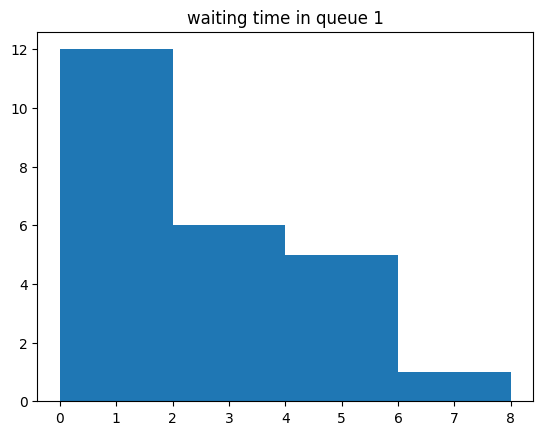

In [98]:
# waiting time in queue 1
revised_Q1_wt = np.array(Q1_wt)
revised_Q1_wt = revised_Q1_wt[revised_Q1_wt != 0]
m = round(math.sqrt(len(revised_Q1_wt)))
step = round((max(revised_Q1_wt) - min(revised_Q1_wt)) /m)
bins = [step * i for i in range(m)]
plt.title("waiting time in queue 1")
plt.hist(revised_Q1_wt, bins)
plt.show()

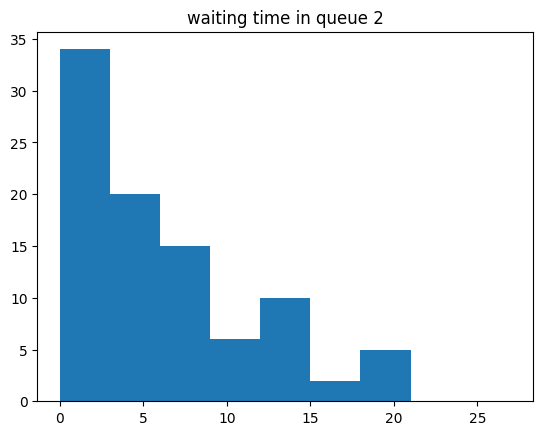

In [99]:
# waiting time in queue 2
revised_Q2_wt = np.array(Q2_wt)
revised_Q2_wt = revised_Q2_wt[revised_Q2_wt != 0]
m = round(math.sqrt(len(revised_Q2_wt)))
step = round((max(revised_Q2_wt) - min(revised_Q2_wt)) /m)
bins = [step * i for i in range(m)]
plt.title("waiting time in queue 2")
plt.hist(revised_Q2_wt, bins)
plt.show()

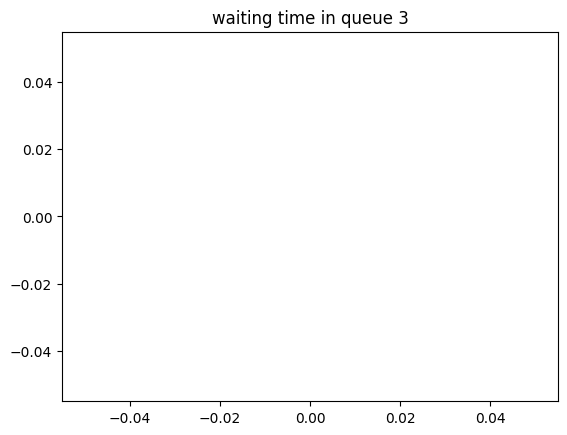

In [100]:
# waiting time in queue 3
revised_Q3_wt = np.array(Q3_wt)
revised_Q3_wt = revised_Q3_wt[revised_Q3_wt != 0]
m = round(math.sqrt(len(revised_Q3_wt)))
step = round((max(revised_Q3_wt) - min(revised_Q3_wt)) /m)
bins = [step * i for i in range(m)]
plt.title("waiting time in queue 3")
plt.hist(revised_Q3_wt, bins)
plt.show()

## results - input modeling

In [101]:
def histogram_plotter(data,bins):
    plt.figure()
    plt.hist(data , bins=bins,color='black')
    plt.xlabel('data')
    plt.ylabel('frequency')
    plt.tight_layout()
    plt.show()

In [102]:
def QQPLOT_exponential(data,lambda_param):
     
    
    data = np.array(sorted(data))
    
    x_axis = stats.expon.ppf((np.arange(1, len(data)+1) - 0.5) / len(data), scale=1/lambda_param)
    y_axis = data
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_axis, y_axis, color='blue', marker='o')
    plt.plot([x_axis.min(), x_axis.max()], [x_axis.min(), x_axis.max()], color='red', linestyle='--')
    plt.xlabel('Theoretical Quantiles (Exponential)')
    plt.ylabel('Sample Quantiles')
    plt.title('Q-Q Plot (Exponential Distribution)')
    plt.tight_layout()
    plt.show()

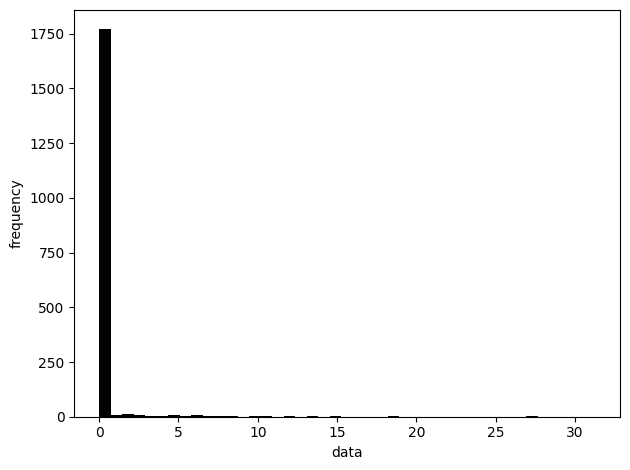

In [103]:
#Histogram p1
bins1=int(len(p1_patients_wt)**0.5)
histogram_plotter(p1_patients_wt,bins1)

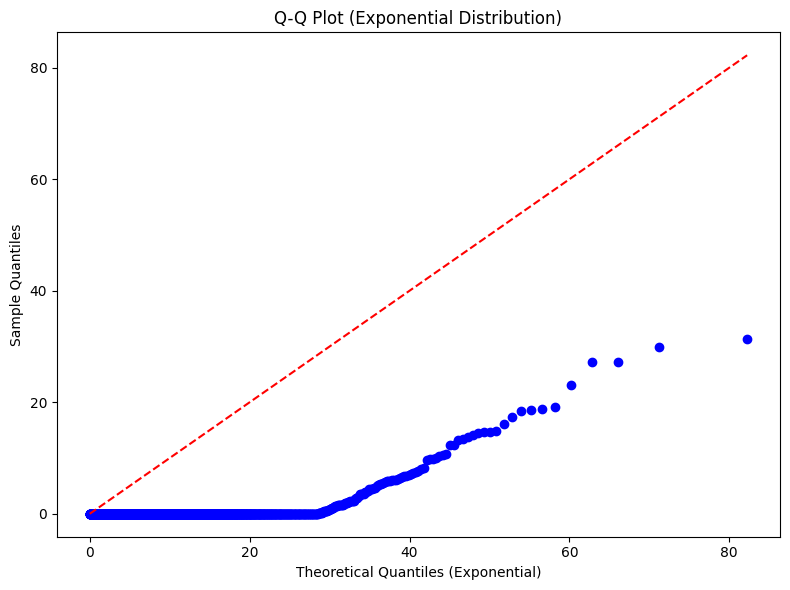

In [104]:
#QQ-plot p1 without know param
QQPLOT_exponential(p1_patients_wt,0.1)

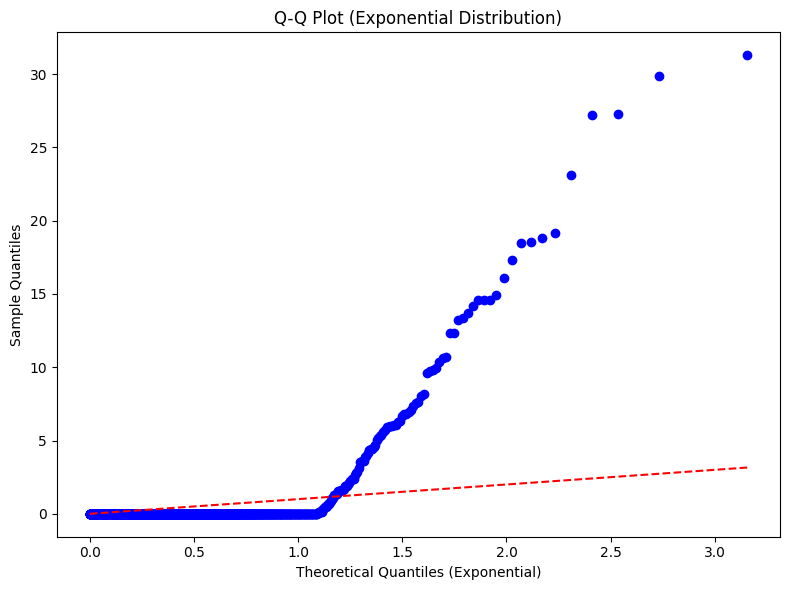

lambda param p1= 2.6064691602990857


In [105]:
#lambda param p1
lambda_param = 1 / np.mean(p1_patients_wt)
QQPLOT_exponential(p1_patients_wt,lambda_param)
print("lambda param p1=",lambda_param)

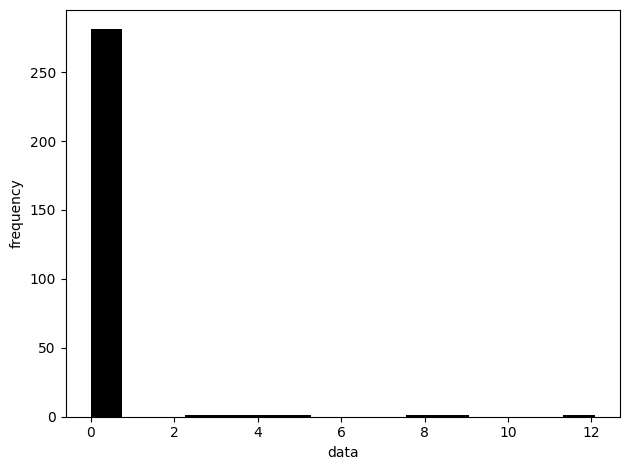

In [106]:
#Histogram p3
bins3=int(len(p3_patients_wt)**0.5)
histogram_plotter(p3_patients_wt,bins3)

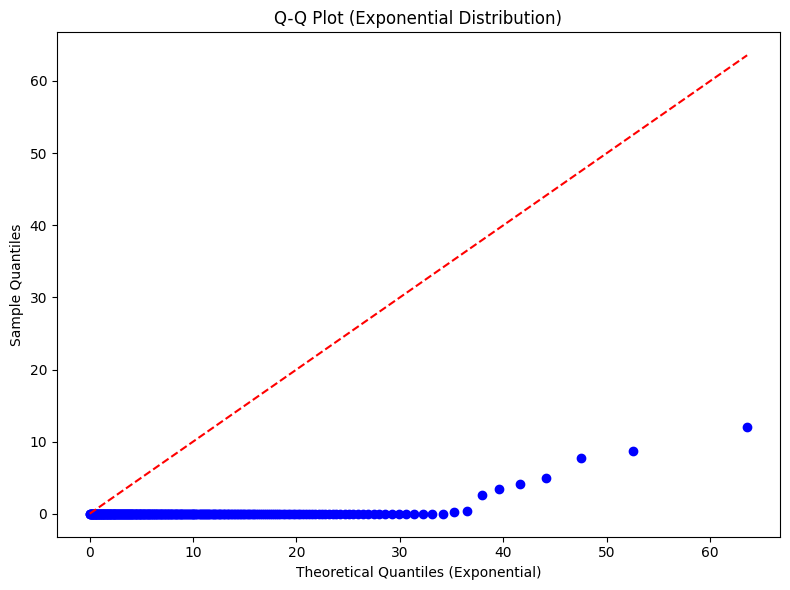

In [107]:
#QQ-plot p3 without know param
QQPLOT_exponential(p3_patients_wt,0.1)

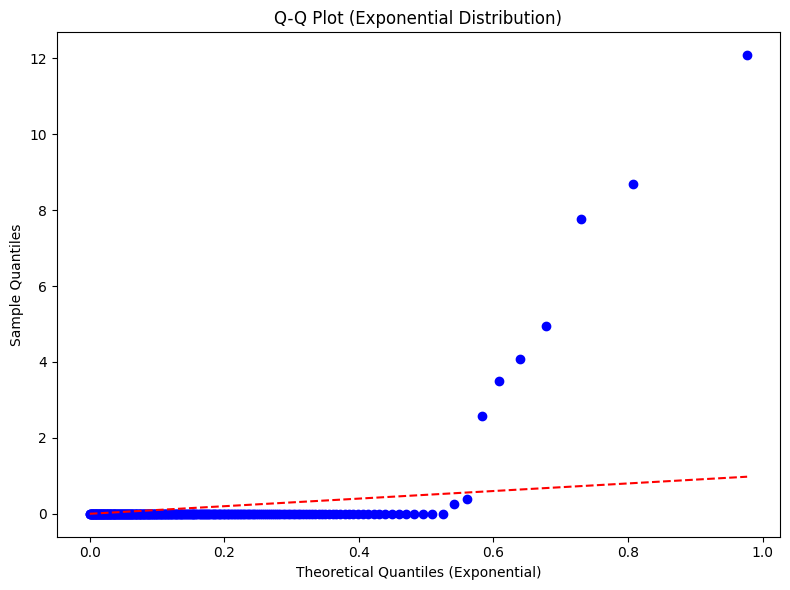

lambda param p3= 6.5064661794228575


In [108]:
#lambda param p3
lambda_param = 1 / np.mean(p3_patients_wt)
QQPLOT_exponential(p3_patients_wt,lambda_param)
print("lambda param p3=",lambda_param)

## Results for initialization

In [109]:
final_tablei = []
header = ['patient No', 'clock of arrival', 'time service 1 begins', 'service time 1', 'time service end 1','time service 2 begins', 'service time 2', 'time service end 2', 'priority', 'total waiting time', ' wt1', 'wt2']
main_patients = sorted(initialization_patients, key=lambda x: x.NO)

for patient in main_patients:
    final_tablei.append([patient.NO + 1, patient.arrival, patient.end1 - patient.service_time1, patient.service_time1, patient.end1, patient.end2 - patient.service_time2, patient.service_time2, patient.end2,patient.priority, patient.twt, patient.wt1, patient.wt2])

In [110]:
df = pd.DataFrame(final_tablei)
df.columns = header
columns_to_convert = ['clock of arrival', 'time service 1 begins','time service end 1','time service 2 begins', 'time service end 2']
for col in columns_to_convert:
    df[col] = df[col].apply(convert_minutes_to_dd_hh_mm_ss)
df.head(50)

,patient No,clock of arrival,time service 1 begins,service time 1,time service end 1,time service 2 begins,service time 2,time service end 2,priority,total waiting time,wt1,wt2
0,1,00:00:00:00,00:00:00:00,25.646690,00:00:25:38,00:00:25:38,43.663515,00:01:09:18,3,7.105427e-15,0.00000,7.105427e-15
1,2,00:00:18:38,00:00:18:38,17.773037,00:00:36:24,00:00:36:24,14.263541,00:00:50:40,1,0.000000e+00,0.00000,0.000000e+00
2,3,00:00:36:48,00:00:36:48,19.206437,00:00:56:00,00:00:56:00,8.481731,00:01:04:29,1,-7.105427e-15,0.00000,-7.105427e-15
3,4,00:00:58:06,00:00:58:06,20.838918,00:01:18:56,00:01:18:56,5.421994,00:01:24:22,1,0.000000e+00,0.00000,0.000000e+00
4,5,00:01:26:05,00:01:26:05,22.977039,00:01:49:04,00:01:49:04,14.062423,00:02:03:07,1,1.421085e-14,0.00000,1.421085e-14
5,6,00:01:42:40,00:01:42:40,5.155091,00:01:47:49,00:01:47:49,1.170224,00:01:48:59,1,0.000000e+00,0.00000,0.000000e+00
6,7,00:02:04:11,00:02:04:11,26.100787,00:02:30:17,00:02:30:17,13.969775,00:02:44:15,1,0.000000e+00,0.00000,0.000000e+00
7,8,00:02:18:35,00:02:18:35,3.671755,00:02:22:15,00:02:22:15,21.201290,00:02:43:27,1,0.000000e+00,0.00000,0.000000e+00
8,9,00:02:35:46,00:02:35:46,9.164469,00:02:44:56,00:02:44:56,6.312188,00:02:51:14,1,0.000000e+00,0.00000,0.000000e+00
9,10,00:03:01:53,00:03:01:53,5.712929,00:03:07:36,00:03:07:36,7.474954,00:03:15:05,1,0.000000e+00,0.00000,0.000000e+00


In [111]:
print(f'The maximum length of Queue 1 (for low priority patients behind first doctor) is: {maxii[0]:n} and the mean is: {meani[0]:n} with standard deviation of {sigmai[0]:n}.')
print(f'The maximum length of Queue 3 (for high priority patients behind first doctor) is: {maxii[1]:n} and the mean is: {meani[1]:n} with standard deviation of {sigmai[1]:n}.')
print(f'The maximum length of Queue 2 (for all patients behind second doctor) is: {maxii[2]:n} and the mean is: {meani[2]:n} with standard deviation of {sigmai[2]:n}.')
print(f'Patients with high priority that didnt wait are: {not_waitedi[1]:n}% .\nPatients with low priority that didnt wait are: {not_waitedi[0]:n}%.')
print(f'Total percentage of patients that didnt wait is: {not_waitedi[2]:n}%')
print(f'Patients with high priority that waited less than 4 mins are: {less_4i[1]:n}% .\nPatients with low priority that that waited less than 4 mins are: {less_4i[0]:n}%.')
print(f'Total percentage of patients that that waited less than 4 mins is: {less_4i[2]:n}%')

The maximum length of Queue 1 (for low priority patients behind first doctor) is: 1 and the mean is: 0.00229358 with standard deviation of 0.0478913.
The maximum length of Queue 3 (for high priority patients behind first doctor) is: 2 and the mean is: 0.0252294 with standard deviation of 0.171018.
The maximum length of Queue 2 (for all patients behind second doctor) is: 1 and the mean is: 0.00229358 with standard deviation of 0.0478913.
Patients with high priority that didnt wait are: 95.4545% .
Patients with low priority that didnt wait are: 99.1935%.
Total percentage of patients that didnt wait is: 98.6301%
Patients with high priority that waited less than 4 mins are: 100% .
Patients with low priority that that waited less than 4 mins are: 99.1935%.
Total percentage of patients that that waited less than 4 mins is: 99.3151%


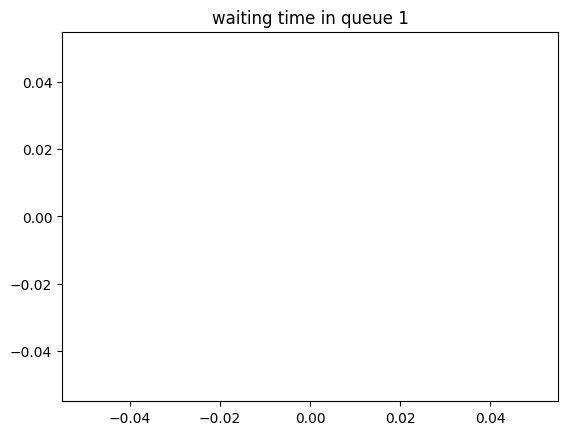

In [112]:
# waiting time in queue 1
revised_Q1i_wt = np.array(Q1i_wt)
revised_Q1i_wt = revised_Q1i_wt[revised_Q1i_wt != 0]
m = round(math.sqrt(len(revised_Q1i_wt)))
step = round((max(revised_Q1i_wt) - min(revised_Q1i_wt)) /m)
bins = [step * i for i in range(m)]
plt.title("waiting time in queue 1")
plt.hist(revised_Q1i_wt, bins)
plt.show()

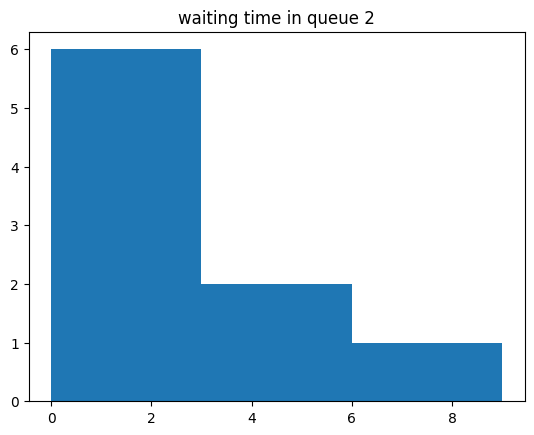

In [113]:
# waiting time in queue 2
revised_Q2i_wt = np.array(Q2i_wt)
revised_Q2i_wt = revised_Q2i_wt[revised_Q2i_wt != 0]
m = round(math.sqrt(len(revised_Q2i_wt)))
step = round((max(revised_Q2i_wt) - min(revised_Q2i_wt)) /m)
bins = [step * i for i in range(m)]
plt.title("waiting time in queue 2")
plt.hist(revised_Q2i_wt, bins)
plt.show()

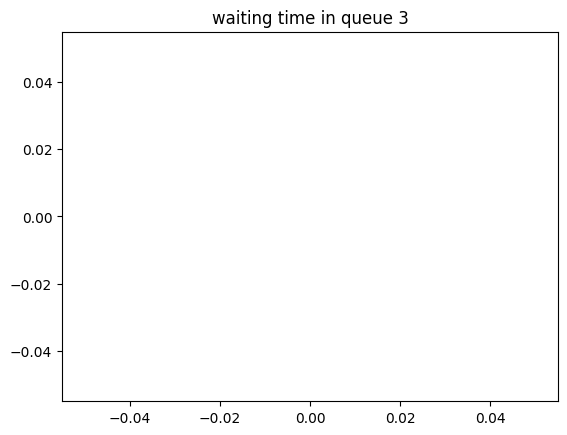

In [114]:
# waiting time in queue 3
revised_Q3i_wt = np.array(Q3i_wt)
revised_Q3i_wt = revised_Q3i_wt[revised_Q3i_wt != 0]
m = round(math.sqrt(len(revised_Q3i_wt)))
step = round((max(revised_Q3i_wt) - min(revised_Q3i_wt)) /m)
bins = [step * i for i in range(m)]
plt.title("waiting time in queue 3")
plt.hist(revised_Q3i_wt, bins)
plt.show()

## initialization results - input modeling

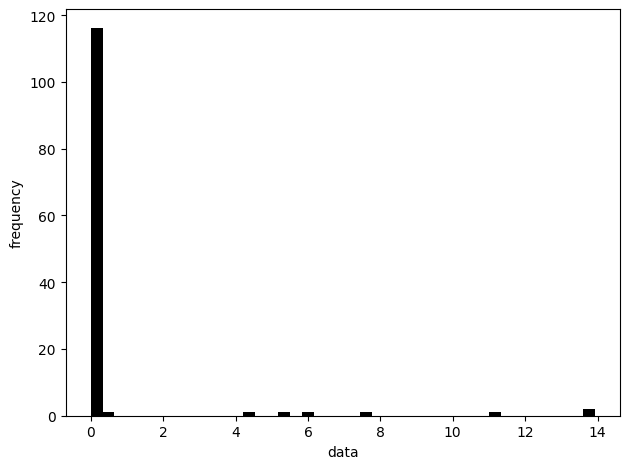

In [115]:
#Histogram p1
bins1=int(len(p1_patients_wt)**0.5)
histogram_plotter(p1_patientsi_wt,bins1)

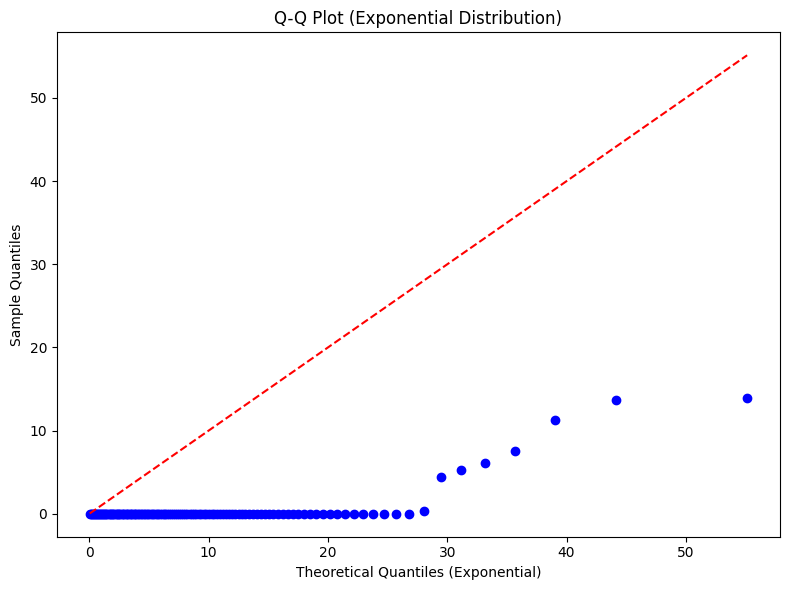

In [116]:
#QQ-plot p1 without know param
QQPLOT_exponential(p1_patientsi_wt,0.1)

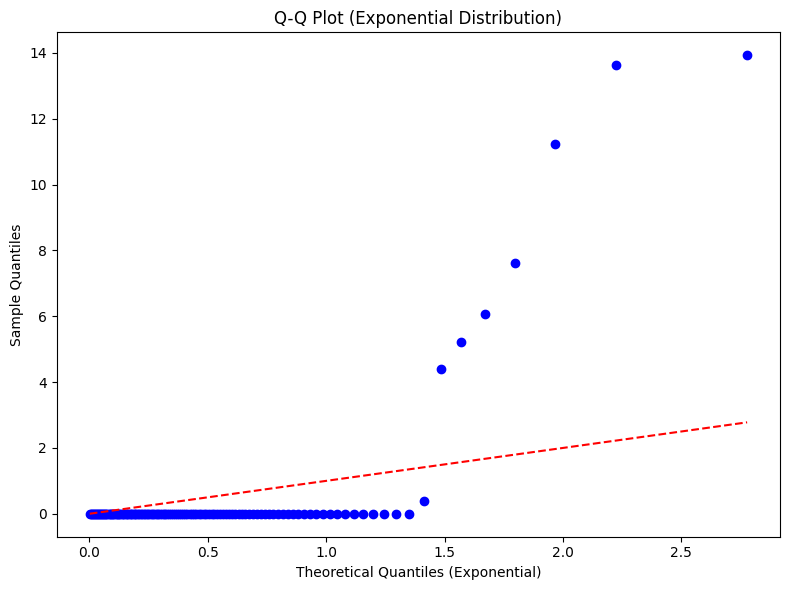

lambda param p1= 1.9849439435572378


In [117]:
#lambda param p1
lambda_param = 1 / np.mean(p1_patientsi_wt)
QQPLOT_exponential(p1_patientsi_wt,lambda_param)
print("lambda param p1=",lambda_param)

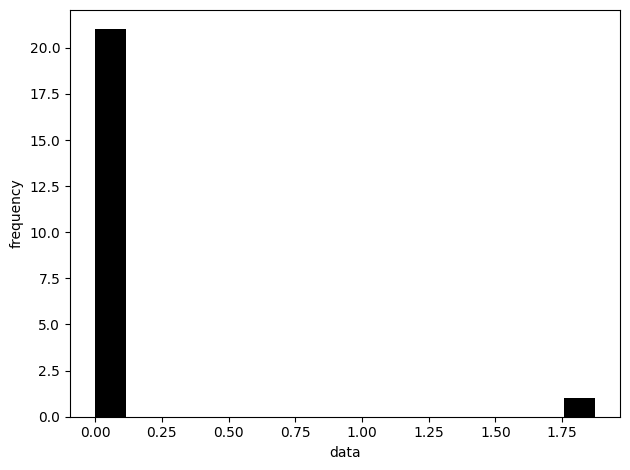

In [118]:
#Histogram p3
bins3=int(len(p3_patients_wt)**0.5)
histogram_plotter(p3_patientsi_wt,bins3)

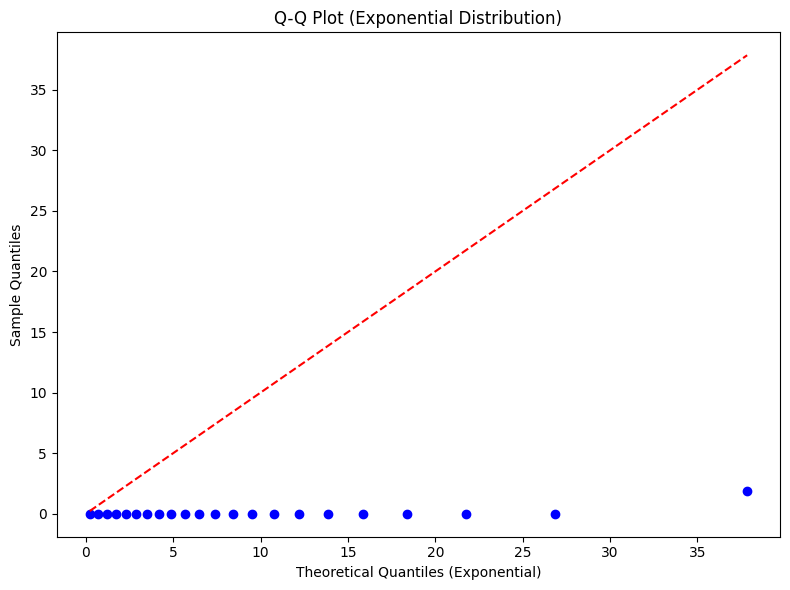

In [119]:
#QQ-plot p3 without know param
QQPLOT_exponential(p3_patientsi_wt,0.1)

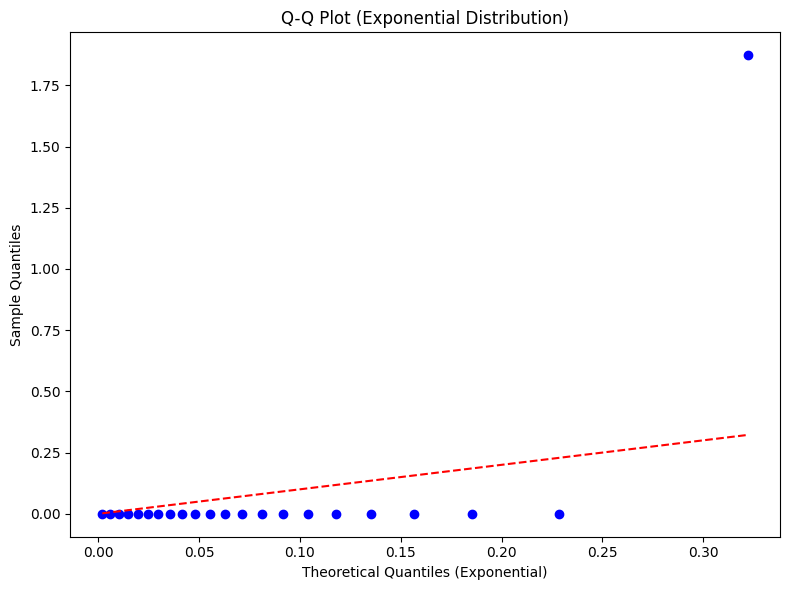

lambda param p3= 11.747099991809527


In [120]:
#lambda param p3
lambda_param = 1 / np.mean(p3_patientsi_wt)
QQPLOT_exponential(p3_patientsi_wt,lambda_param)
print("lambda param p3=",lambda_param)